# Genetic Algorithm for Feature Selection in Customer Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1t97Cffi4io91VyXdga5Ll-rjoRb7Heg5)

## Project Overview

This project implements a genetic algorithm (GA) for optimal feature selection in customer classification tasks. The system combines evolutionary computation principles with machine learning to identify the most relevant features for customer segmentation, enhancing model performance while reducing dimensionality.

## Contributors
- Abolfazl Ranjbar - [GitHub](https://github.com/ImRanjbar)
- Miaad Kimiagari - [GitHub](https://github.com/Miaad2004)
- Taha Najaf - [GitHub](https://github.com/taha-najaf)

**Dataset:** Customer Classification Dataset  
**Algorithm:** Binary-encoded Genetic Algorithm with Tournament Selection  
**Classifier:** Decision Tree with Cross-Validation  
**Objective:** Maximize classification accuracy through optimal feature subset selection

## Dataset Loading and Initialization

Loading the customer classification dataset from Google Drive and performing initial data exploration. The dataset contains customer behavioral attributes used for market segmentation analysis.

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive')
!unzip -o "/content/drive/MyDrive/Customer Classification dataset.zip" -d "/ds/"

train_df = pd.read_csv("/ds/Customer Classification dataset/Train.csv")
test_df = pd.read_csv("/ds/Customer Classification dataset/Test.csv")

train_df.tail()

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Customer Classification dataset.zip
  inflating: /ds/Customer Classification dataset/Data Description.pdf  
  inflating: /ds/Customer Classification dataset/Test.csv  
  inflating: /ds/Customer Classification dataset/Train.csv  


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B
8067,461879,Male,Yes,37,Yes,Executive,0.0,Average,3.0,Cat_4,B


## Exploratory Data Analysis

Comprehensive statistical analysis of the customer dataset including missing value assessment, feature distribution analysis, and data quality evaluation to inform preprocessing strategies.

In [2]:
print(f"Test df size: {len(test_df)}")
print(f"Number of rows with missing values (Test_ds): {test_df.isna().any(axis=1).sum()}\n")

print(f"Train df size: {len(train_df)}")
print(f"Number of rows with missing values (Train_ds): {train_df.isna().any(axis=1).sum()}")

Test df size: 2627
Number of rows with missing values (Test_ds): 473

Train df size: 8068
Number of rows with missing values (Train_ds): 1403


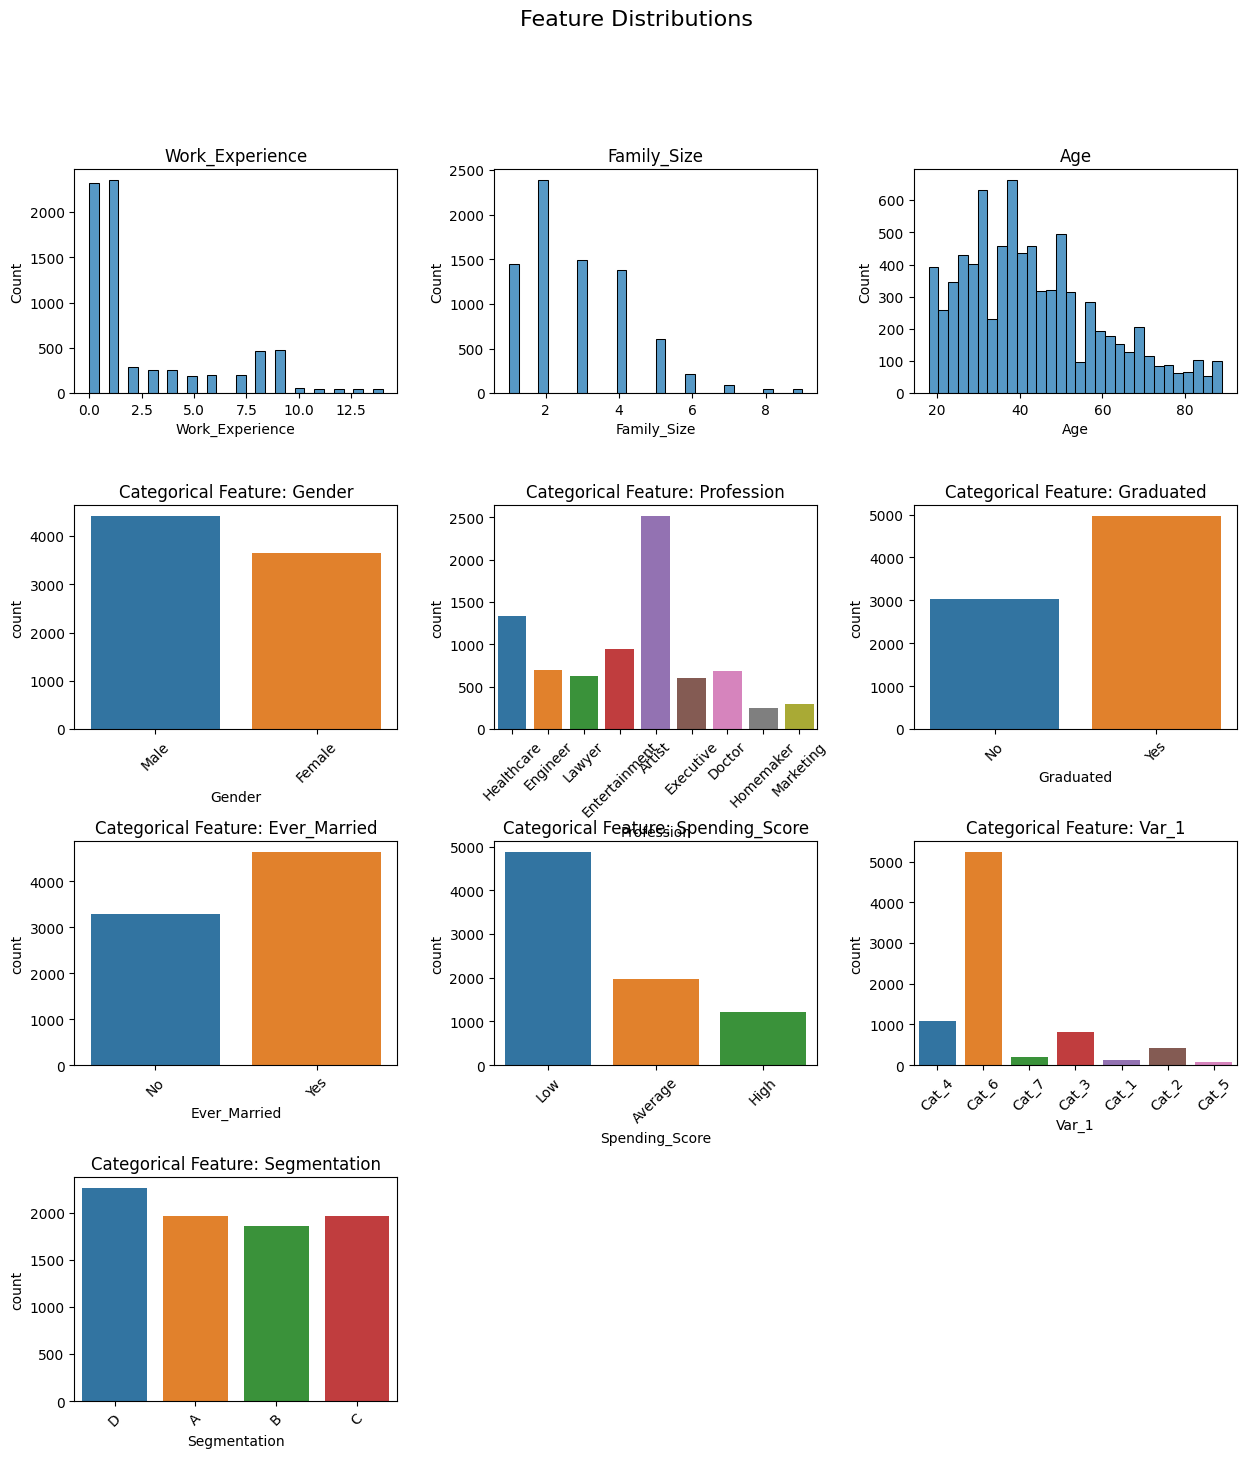

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math

def plot_feature_distributions(df: pd.DataFrame, exclude=[]):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    numeric_cols = list(set(numeric_cols) - set(exclude))
    categorical_cols = list(set(categorical_cols) - set(exclude))

    num_plots = len(numeric_cols) + len(categorical_cols)
    cols = 3  # n cols
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], bins=30, ax=axes[i], edgecolor='black')
        axes[i].set_title(col, fontsize=12)

    for i, col in enumerate(categorical_cols, start=len(numeric_cols)):
        sns.countplot(data=df, x=col, hue=col, legend=False, ax=axes[i])
        axes[i].set_title(f"Categorical Feature: {col}", fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.suptitle("Feature Distributions", fontsize=16)
    plt.savefig("fig.png", bbox_inches='tight', dpi=300)
    plt.show()


plot_feature_distributions(train_df, exclude=["ID"])


## Data Preprocessing and Feature Engineering

Implementation of comprehensive data preprocessing pipeline including missing value imputation, outlier detection using Interquartile Range (IQR) method, and categorical encoding. This preprocessing ensures data quality and consistency for the genetic algorithm optimization process.

In [ ]:
def handle_missing_values_inplace(data_frame: pd.DataFrame) -> None:
  numeric_cols = data_frame.select_dtypes(include=[np.number]).columns.tolist()

  # handle missing vals for numerical features (assumin ID's not missing)
  # usin median
  numeric_cols = data_frame.select_dtypes(include=[np.number]).columns.tolist()
  print("Numeric Columns:", numeric_cols)

  for col in numeric_cols:
    data_frame[col] = data_frame[col].fillna(data_frame[col].median())

  # for categorical features....
  # using mode
  categorical_cols = data_frame.select_dtypes(include=['object']).columns.tolist()
  print("Categorical Columns:", categorical_cols)

  for col in categorical_cols:
    data_frame[col] = data_frame[col].fillna(data_frame[col].mode()[0])

def remove_outlier(df: pd.DataFrame, exclude_cols=[], k=1.5) -> pd.DataFrame:
  """
  Removes the outliers using IQR (only for numeric cols)
  """

  init_len = len(df)

  cols = df.select_dtypes(include=[np.number]).columns.tolist()
  for col in cols:
    if col in exclude_cols:
      continue

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    df = df.loc[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

  print(f"Removed {init_len - len(df)} outliers.")
  return df

def encode(train_df: pd.DataFrame, test_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    categorical_cols = train_df.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        all_categories = pd.concat([train_df[col], test_df[col]]).unique()

        train_df[col] = pd.Categorical(train_df[col], categories=all_categories).codes
        test_df[col] = pd.Categorical(test_df[col], categories=all_categories).codes

    return train_df, test_df



In [ ]:
handle_missing_values_inplace(train_df)
handle_missing_values_inplace(test_df)

train_df = remove_outlier(train_df, exclude_cols=["ID"])
test_df = remove_outlier(test_df, exclude_cols=["ID"])

train_df, test_df = encode(train_df, test_df)

print("")
train_df.tail()

Numeric Columns: ['ID', 'Age', 'Work_Experience', 'Family_Size']
Categorical Columns: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']
Numeric Columns: ['ID', 'Age', 'Work_Experience', 'Family_Size']
Categorical Columns: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']
Removed 348 outliers.
Removed 402 outliers.



,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
8063,464018,0,0,22,0,4,0.0,0,7.0,4,0
8064,464685,0,0,35,0,5,3.0,0,4.0,0,0
8065,465406,1,0,33,1,0,1.0,0,1.0,1,0
8066,467299,1,0,27,1,0,1.0,0,4.0,1,2
8067,461879,0,1,37,1,5,0.0,1,3.0,0,2


In [ ]:
test_df.tail()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
2620,467949,0,0,21,0,0,1.0,0,4.0,0,0
2621,467950,1,0,35,1,3,1.0,0,2.0,1,0
2623,467958,1,0,35,1,6,1.0,0,1.0,1,1
2624,467960,1,0,53,1,3,1.0,0,2.0,1,3
2625,467961,0,1,47,1,5,1.0,2,5.0,0,3


In [ ]:
y_train, y_test = train_df['Segmentation'], test_df['Segmentation']
x_train, x_test = train_df.drop(columns=['ID', 'Segmentation']), test_df.drop(columns=['ID', 'Segmentation'])


## Feature Correlation Analysis

Statistical correlation analysis between features and target variables to establish baseline feature importance metrics. This analysis provides insights into linear relationships and serves as a benchmark for genetic algorithm feature selection performance.

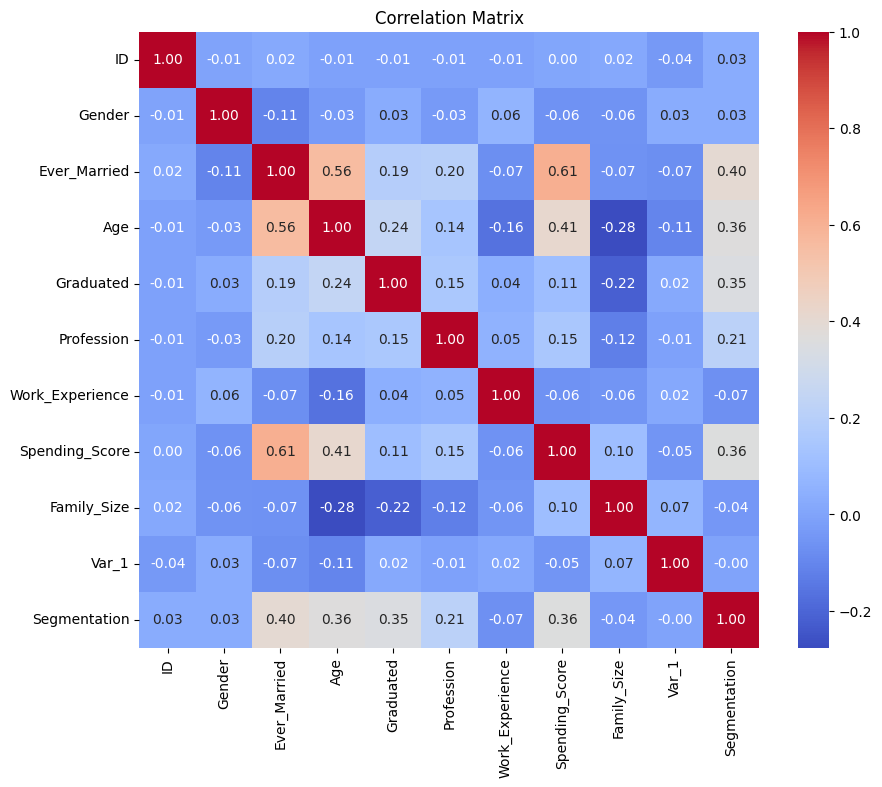

Features with the strongest correlation to Segmentation:
Segmentation       1.000000
Ever_Married       0.397322
Age                0.363428
Spending_Score     0.358029
Graduated          0.347867
Profession         0.213211
Work_Experience    0.068922
Family_Size        0.042094
Gender             0.031762
ID                 0.028035
Var_1              0.002204
Name: Segmentation, dtype: float64


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = train_df
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

target_corr = corr_matrix['Segmentation'].abs().sort_values(ascending=False)

print("Features with the strongest correlation to Segmentation:")
print(target_corr)


## Genetic Algorithm Implementation

Implementation of a binary-encoded genetic algorithm for feature selection optimization. The algorithm employs evolutionary computation principles including population initialization, fitness evaluation, selection mechanisms, crossover operations, and mutation strategies to identify optimal feature subsets for customer classification.

### Population Initialization Strategy

Binary chromosome representation where each gene corresponds to a feature selection decision. The initialization process ensures genetic diversity while maintaining constraint satisfaction (minimum one feature selected per chromosome).

In [ ]:
# Chromosomes are represented as binary vecs

def gen_init_population(pop_size, n_features):
  population = []

  for _ in range(pop_size):
    chromosome = np.random.randint(2, size=n_features)

    # make sure at least 1 feature is selected
    if not sum(chromosome):
      chromosome[np.random.randint(n_features)] = 1

    population.append(chromosome)

  return np.array(population)

gen_init_population(10, 5)

array([[1, 1, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1],
       [1, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 0, 0, 0]])

### Fitness Function Design

Decision tree-based fitness evaluation using classification accuracy as the optimization objective. The fitness function assesses chromosome quality through train-test split validation, providing robust performance metrics for evolutionary selection.

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def fitness_evaluation(chromosome, feature_matrix, target_labels):
    #Evaluates the fitness of a given chromosome by training a Decision Tree and the accuracy return
    selected_feature_indices = np.where(chromosome == 1)[0]
    if len(selected_feature_indices) == 0:
        return 0

    selected_features = feature_matrix[:, selected_feature_indices]

    X_train, X_test, y_train, y_test = train_test_split(selected_features, target_labels, test_size=0.2, random_state=50)

    classifier = DecisionTreeClassifier(random_state=50)
    classifier.fit(X_train, y_train)

    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    return accuracy


    from sklearn.model_selection import cross_val_score


# def fitness_evaluation2(chromosome, feature_matrix, target_labels):
#     selected_feature_indices = np.where(chromosome == 1)[0]

#     if len(selected_feature_indices) == 0:
#         return 0

#     selected_features = feature_matrix[:, selected_feature_indices]

#     classifier = DecisionTreeClassifier(random_state=50)

#     # using 4-fold cross validation
#     cv_scores = cross_val_score(classifier, selected_features, target_labels, cv=4, scoring='accuracy')

#     return np.mean(cv_scores)


### Parent Selection Mechanisms

Implementation of tournament selection and roulette wheel selection strategies. Tournament selection provides selective pressure while maintaining population diversity, whereas roulette wheel selection implements fitness-proportionate selection for balanced exploration-exploitation trade-offs.

In [ ]:
def tournament_selection(population, fitness_scores, tournament_size=3):
  """
  Selects a parent using tournament selection.
  """
  selected_indices = np.random.choice(len(population), tournament_size, replace=False)
  selected_fitness = fitness_scores[selected_indices]
  winner_index = selected_indices[np.argmax(selected_fitness)]
  return population[winner_index]

def roulette_wheel_selection(population, fitness_scores):
  """
  Selects a parent using roulette wheel selection.
  """
  total_fitness = np.sum(fitness_scores)
  if total_fitness == 0:
    probabilities = np.ones(len(fitness_scores)) / len(fitness_scores)

  else:
    probabilities = fitness_scores / total_fitness

  selected_index = np.random.choice(len(population), p=probabilities)
  return population[selected_index]

In [ ]:
# Example usage:
population = gen_init_population(10, x_train.shape[1])
fitness_scores = np.array([fitness_evaluation(chromosome, x_train.values, y_train.values) for chromosome in population])
parent = tournament_selection(population, fitness_scores)
print("Selected Parent:", parent)


parent_roulette = roulette_wheel_selection(population, fitness_scores)
print("Selected Parent (Roulette):", parent_roulette)

Selected Parent: [0 0 0 0 1 0 0 1 0]
Selected Parent (Roulette): [1 1 1 0 0 1 0 1 1]


### Crossover Operations

Implementation of single-point and uniform crossover operators for genetic recombination. These operators facilitate information exchange between parent chromosomes while preserving beneficial feature combinations through controlled genetic material transfer.

In [ ]:
def single_point_crossover(parent1: np.ndarray, parent2: np.ndarray, crossover_rate: float = 0.8) -> tuple[np.ndarray, np.ndarray]: # WHY 0.8?!!!
  if len(parent1) != len(parent2):
    raise ValueError("Parents must have the same length")

  if np.random.rand() < crossover_rate:
    crossover_point = np.random.randint(1, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))


  else:
    child1 = parent1
    child2 = parent2

  return child1, child2

def uniform_crossover(parent1: np.ndarray, parent2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
  if len(parent1) != len(parent2):
    raise ValueError("Parents must have the same length")

  child1 = np.where(np.random.rand(len(parent1)) < 0.5, parent1, parent2)
  child2 = np.where(np.random.rand(len(parent1)) < 0.5, parent2, parent1)

  return child1, child2

### Mutation Strategy

Bit-flip mutation operator with adaptive rate control to maintain population diversity and prevent premature convergence. The mutation mechanism includes constraint enforcement to ensure valid chromosome configurations.

In [ ]:
def mutate_chromosome(chromosome, mutation_rate=0.05):
    mutated = chromosome.copy()
    for i in range(len(mutated)):
        if np.random.rand() < mutation_rate:
            mutated[i] = 1 - mutated[i]

    if mutated.sum() == 0:
        mutated[np.random.randint(len(mutated))] = 1

    return mutated


### Genetic Algorithm Execution

Complete evolutionary optimization process integrating all genetic operators with convergence criteria and feature importance ranking. The algorithm tracks generational progress and implements early stopping based on fitness plateau detection.

In [ ]:
def genetic_algorithm(
    x_train, y_train, population_size=20, generations=50, mutation_rate=0.05, crossover_rate=0.8, convergence_threshold=5
):
    """
    Runs the Genetic Algorithm for feature selection and ranks features by importance.
    """
    n_features = x_train.shape[1]
    population = gen_init_population(population_size, n_features)
    best_fitness = 0
    convergence_count = 0
    best_chromosome = None
    feature_selection_count = np.zeros(n_features)

    for generation in range(generations):
        fitness_scores = np.array([fitness_evaluation(chromosome, x_train.values, y_train.values) for chromosome in population])
        best_generation_fitness = np.max(fitness_scores)
        best_generation_chromosome = population[np.argmax(fitness_scores)]

        # updating freq
        feature_selection_count += best_generation_chromosome

        print(f"Generation {generation + 1}: Best Fitness = {best_generation_fitness}")

        # convergance check
        if best_generation_fitness > best_fitness:
            best_fitness = best_generation_fitness
            best_chromosome = best_generation_chromosome
            convergence_count = 0

        else:
            convergence_count += 1

        if convergence_count >= convergence_threshold:
            print("Convergence reached!")
            break

        # Selection and Evolution
        new_population = []
        for _ in range(population_size // 2):
            parent1 = tournament_selection(population, fitness_scores)
            parent2 = tournament_selection(population, fitness_scores)

            # Crossover
            child1, child2 = single_point_crossover(parent1, parent2, crossover_rate)

            # Mutation
            child1 = mutate_chromosome(child1, mutation_rate)
            child2 = mutate_chromosome(child2, mutation_rate)

            new_population.extend([child1, child2])

        population = np.array(new_population)

    # rank by selection freq
    feature_importance = sorted(
        zip(x_train.columns, feature_selection_count),
        key=lambda x: x[1],
        reverse=True
    )

    print("\nBest Chromosome:", best_chromosome)
    print("Best Fitness:", best_fitness)

    selected_features = [feature for feature, bit in zip(x_train.columns, best_chromosome) if bit == 1]

    print("\nSelected features in the best chromosome:")
    print(selected_features)

    print("\nTop features:")
    for i, (feature, count) in enumerate(feature_importance):
          print(f"{i + 1}) {feature}: {count}")

    return best_chromosome, feature_importance


best_chromosome, ranked_features = genetic_algorithm(x_train, y_train)


Generation 1: Best Fitness = 0.45466321243523317
Generation 2: Best Fitness = 0.4643782383419689
Generation 3: Best Fitness = 0.469559585492228
Generation 4: Best Fitness = 0.469559585492228
Generation 5: Best Fitness = 0.469559585492228
Generation 6: Best Fitness = 0.469559585492228
Generation 7: Best Fitness = 0.469559585492228
Generation 8: Best Fitness = 0.47150259067357514
Generation 9: Best Fitness = 0.47150259067357514
Generation 10: Best Fitness = 0.47150259067357514
Generation 11: Best Fitness = 0.47150259067357514
Generation 12: Best Fitness = 0.47150259067357514
Generation 13: Best Fitness = 0.47150259067357514
Convergence reached!

Best Chromosome: [0 1 0 1 1 0 1 0 0]
Best Fitness: 0.47150259067357514

Selected features in the best chromosome:
['Ever_Married', 'Graduated', 'Profession', 'Spending_Score']

Top features:
1) Profession: 13.0
2) Spending_Score: 13.0
3) Graduated: 12.0
4) Ever_Married: 11.0
5) Gender: 7.0
6) Age: 1.0
7) Family_Size: 1.0
8) Work_Experience: 0.0
9

## Model Evaluation and Performance Analysis

Comprehensive evaluation of decision tree classifiers using different feature subset configurations. Performance assessment includes accuracy, F1-score, and detailed classification metrics to validate the effectiveness of genetic algorithm feature selection.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def train_and_evaluate_decision_tree(x_train, y_train, x_test, y_test, selected_features, top_n=None):
    selected_feature_names = [x_train.columns[i] for i in range(len(selected_features)) if selected_features[i] == 1]
    if top_n:
        selected_feature_names = [feature for feature, _ in ranked_features[:top_n]]

    x_train_selected = x_train[selected_feature_names]
    x_test_selected = x_test[selected_feature_names]

    classifier = DecisionTreeClassifier(random_state=50)
    classifier.fit(x_train_selected, y_train)
    y_pred = classifier.predict(x_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print report
    print(f"Selected Features ({'Top ' + str(top_n) if top_n else 'All'}):", selected_feature_names)
    print("\nModel Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", conf_matrix)
    print("--------------------------------------------------------")

    return classifier, selected_feature_names, accuracy

# Evaluate models with different feature sets
classifier_top3, selected_top3, acc_top3 = train_and_evaluate_decision_tree(
    x_train, y_train, x_test, y_test, best_chromosome, top_n=3)

classifier_top5, selected_top5, acc_top5 = train_and_evaluate_decision_tree(
    x_train, y_train, x_test, y_test, best_chromosome, top_n=5)

classifier_top8, selected_top8, acc_top8 = train_and_evaluate_decision_tree(
    x_train, y_train, x_test, y_test, best_chromosome, top_n=8)

classifier_all, selected_all, acc_all  = train_and_evaluate_decision_tree(
    x_train, y_train, x_test, y_test, best_chromosome, top_n=len(ranked_features))



Selected Features (Top 3): ['Profession', 'Spending_Score', 'Graduated']

Model Performance:
Accuracy: 0.3204
F1 Score: 0.3234

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.38      0.40       635
           1       0.35      0.28      0.31       715
           2       0.23      0.27      0.25       467
           3       0.27      0.34      0.30       408

    accuracy                           0.32      2225
   macro avg       0.32      0.32      0.32      2225
weighted avg       0.33      0.32      0.32      2225


Confusion Matrix:
 [[243 149 132 111]
 [172 202 192 149]
 [ 98 126 128 115]
 [ 58  99 111 140]]
--------------------------------------------------------
Selected Features (Top 5): ['Profession', 'Spending_Score', 'Graduated', 'Ever_Married', 'Gender']

Model Performance:
Accuracy: 0.3236
F1 Score: 0.3222

Classification Report:
               precision    recall  f1-score   support

           0       0.40   

### Performance Visualization and Comparative Analysis

Graphical representation of model performance across different feature subset sizes, demonstrating the trade-off between feature dimensionality and classification accuracy through comprehensive metric visualization.

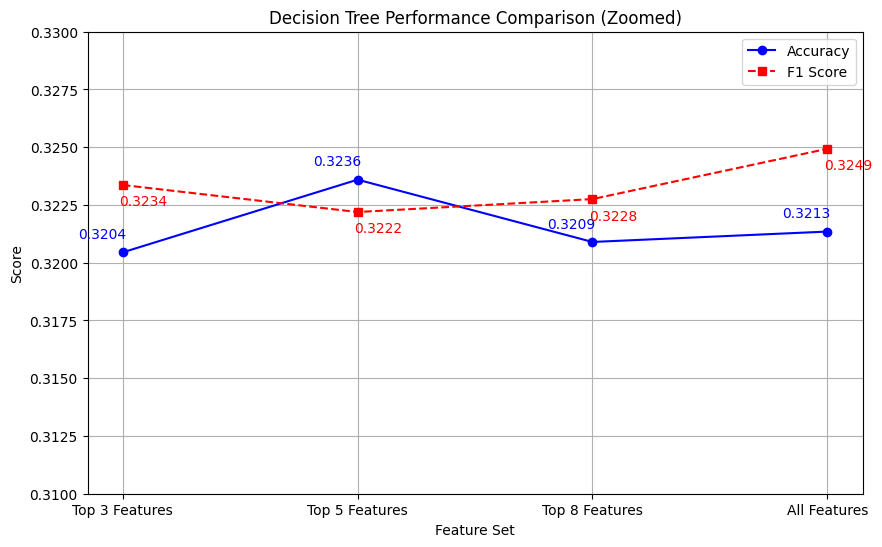

In [ ]:
# --- Plot Performance Comparison ---
methods = ['Top 3 Features', 'Top 5 Features', 'Top 8 Features', 'All Features']
accuracies = [acc_top3, acc_top5, acc_top8, acc_all]
f1_scores   = [f1_top3, f1_top5, f1_top8, f1_all]

x_positions = range(len(methods))

plt.figure(figsize=(10, 6))
plt.plot(x_positions, accuracies, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.plot(x_positions, f1_scores, marker='s', linestyle='--', color='red', label='F1 Score')

# Annotate each data point for Accuracy and F1 Score
for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
    # Accuracy annotation: slightly left and above
    plt.annotate(
        f'{acc:.4f}',
        xy=(i, acc),
        xytext=(-15, 10),
        textcoords='offset points',
        ha='center',
        color='blue'
    )
    # F1 annotation: slightly right and below
    plt.annotate(
        f'{f1:.4f}',
        xy=(i, f1),
        xytext=(15, -15),
        textcoords='offset points',
        ha='center',
        color='red'
    )

plt.xticks(x_positions, methods)
plt.ylim(0.31, 0.33)  # Adjust based on your data range to magnify small differences
plt.xlabel('Feature Set')
plt.ylabel('Score')
plt.title('Decision Tree Performance Comparison (Zoomed)')
plt.grid(True)
plt.legend()
plt.show()

### Optimal Feature Subset Discovery

Exhaustive combinatorial analysis to identify the globally optimal feature subset through systematic evaluation of all possible feature combinations. This brute-force approach serves as ground truth validation for genetic algorithm performance.

In [ ]:
from itertools import combinations
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def find_best_feature_combination(x_train, y_train, x_test, y_test, ranked_features):
    best_acc = 0
    best_feature_subset = None
    best_model = None

    total_features = len(ranked_features)

    for n in range(1, total_features + 1):
        for feature_subset in combinations(ranked_features, n):
            selected_features = [feature for feature, _ in feature_subset]

            # train the decision tree
            x_train_selected = x_train[selected_features]
            x_test_selected = x_test[selected_features]

            model = DecisionTreeClassifier(random_state=50)
            model.fit(x_train_selected, y_train)
            y_pred = model.predict(x_test_selected)

            acc = accuracy_score(y_test, y_pred)

            if acc > best_acc:
                best_acc = acc
                best_feature_subset = selected_features
                best_model = model

    print(f"\nBest acc: {best_acc:.4f}")
    print(f"Best feature subset: {best_feature_subset}")
    return best_model, best_feature_subset

best_model, best_features = find_best_feature_combination(x_train, y_train, x_test, y_test, ranked_features)



Best acc: 0.3497
Best feature subset: ['Ever_Married', 'Gender', 'Age']
